## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob
import sys
import numpy as np
import scipy as sp
import scipy.signal
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Scipy version: {sp.__version__}')

Python version: 3.8.5 (default, Aug  5 2020, 08:36:46) 
[GCC 7.3.0]
Numpy version: 1.19.1
Scipy version: 1.5.0


In [2]:


def LoadTroikaDataset():
    """
    Get filenames in considered data directory.
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data (labels)
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def load_troika_data(data_fl):
    """
    Load complete data file with all signals
    :return: dictionary with keys '__header__', '__version__', '__globals__', 'sig'.
        Most important is the signal key 'sig'.
        The sig key contains a matrix with 6 rows:
            row 1: ECG signal (can be used to calculate the reference heart rate signal -> already done, see REF_... files)
            row 2: 1st PPG channel
            row 3: 2nd PPG channel
            row 4: x-axis of acceleration data
            row 5: y-axis of acceleration data
            row 6: z-axis of acceleration data
    """
    return sp.io.loadmat(data_fl)


def LoadTroikaDataFile(data_fl):
    """
    Load data.
    Loads and extracts signals from a troika data file.
    We are only insterested in these signals: one PPG channel (we use the 2nd), the three acceleration data channels.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = load_troika_data(data_fl)['sig']
    return data[2:]


def load_labels(ref_fl):
    """
    load reference signal (label)
    The reference signal contains the ground-truth of heart rate in beats per minute (BPM)
    in an 8 second window. Two consecutive windows are shifted by 2 seconds. This means
    that consecutive windows are overlapping by 6 seconds. First window covers the first 8
    seconds, second window covers 3rd second to 10th second, ...    
    """
    return sp.io.loadmat(ref_fl)['BPM0'].flatten()


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates in BPM.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # Compute pulse rate estimates and estimation confidence.

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, confidence

In [20]:
def bandpassFilter(signal, pass_band, fs):
    # Design an Nth-order digital or analog Butterworth filter and return the filter coefficients
    # N: order of filter
    # pass_band: critical frequencies
    # fs: sampling frequency of the digital system
    b, a = sp.signal.butter(5, pass_band, btype='bandpass', fs=fs)
    # Apply a digital filter forward and backward to a signal
    return sp.signal.filtfilt(b, a, signal)

In [3]:
# sample frequency:
FREQ_SAMPLE = 125
# window sizes in seconds:
WINDOW_LENGTH_SEC = 8
WINDOW_SHIFT_SEC = 2
window_length = WINDOW_LENGTH_SEC * FREQ_SAMPLE
window_shift = WINDOW_SHIFT_SEC * FREQ_SAMPLE
BPM_MIN = 40
BPM_MAX = 240
# transform to Hz:
min_freq = BPM_MIN / 60
max_freq = BPM_MAX / 60

In [5]:
data_fls, ref_fls = LoadTroikaDataset()

for i, data_fl in enumerate(data_fls):
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ppg_ref = load_labels(ref_fls[i])
    print(f"signal length of {data_fl.split('/')[-1]} = {len(ppg)/FREQ_SAMPLE} sec ({len(ppg)})")
    ts_upper = np.arange(0, len(ppg_ref), 1) * WINDOW_SHIFT_SEC + WINDOW_LENGTH_SEC
    print(f"reference signal length (largest upper interval limit): {ts_upper[-1]} sec ({ts_upper[-1]*FREQ_SAMPLE})")
    print()
    assert len(ppg)==len(accx)==len(accy)==len(accz), 'PPG and acceleration signal length do not match'

signal length of DATA_01_TYPE01.mat = 303.496 sec (37937)
reference signal length (largest upper interval limit): 302 sec (37750)

signal length of DATA_02_TYPE02.mat = 302.8 sec (37850)
reference signal length (largest upper interval limit): 302 sec (37750)

signal length of DATA_03_TYPE02.mat = 287.912 sec (35989)
reference signal length (largest upper interval limit): 286 sec (35750)

signal length of DATA_04_TYPE01.mat = 220.608 sec (27576)
reference signal length (largest upper interval limit): 220 sec (27500)

signal length of DATA_04_TYPE02.mat = 298.0 sec (37250)
reference signal length (largest upper interval limit): 298 sec (37250)

signal length of DATA_05_TYPE02.mat = 298.624 sec (37328)
reference signal length (largest upper interval limit): 298 sec (37250)

signal length of DATA_06_TYPE02.mat = 306.984 sec (38373)
reference signal length (largest upper interval limit): 306 sec (38250)

signal length of DATA_07_TYPE02.mat = 293.2 sec (36650)
reference signal length (larges

In [6]:
# import example data
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
acc = np.sqrt(accx**2 + accy**2 + accz**2)

In [ ]:
ppg_filtered = bandpassFilter(signal=ppg, pass_band=(min_freq, max_freq), fs=FREQ_SAMPLE)
accx_filtered = bandpassFilter(signal=accx, pass_band=(min_freq, max_freq), fs=FREQ_SAMPLE)
accy_filtered = bandpassFilter(signal=accy, pass_band=(min_freq, max_freq), fs=FREQ_SAMPLE)
accz_filtered = bandpassFilter(signal=accz, pass_band=(min_freq, max_freq), fs=FREQ_SAMPLE)
acc_filtered = bandpassFilter(signal=acc, pass_band=(min_freq, max_freq), fs=FREQ_SAMPLE)

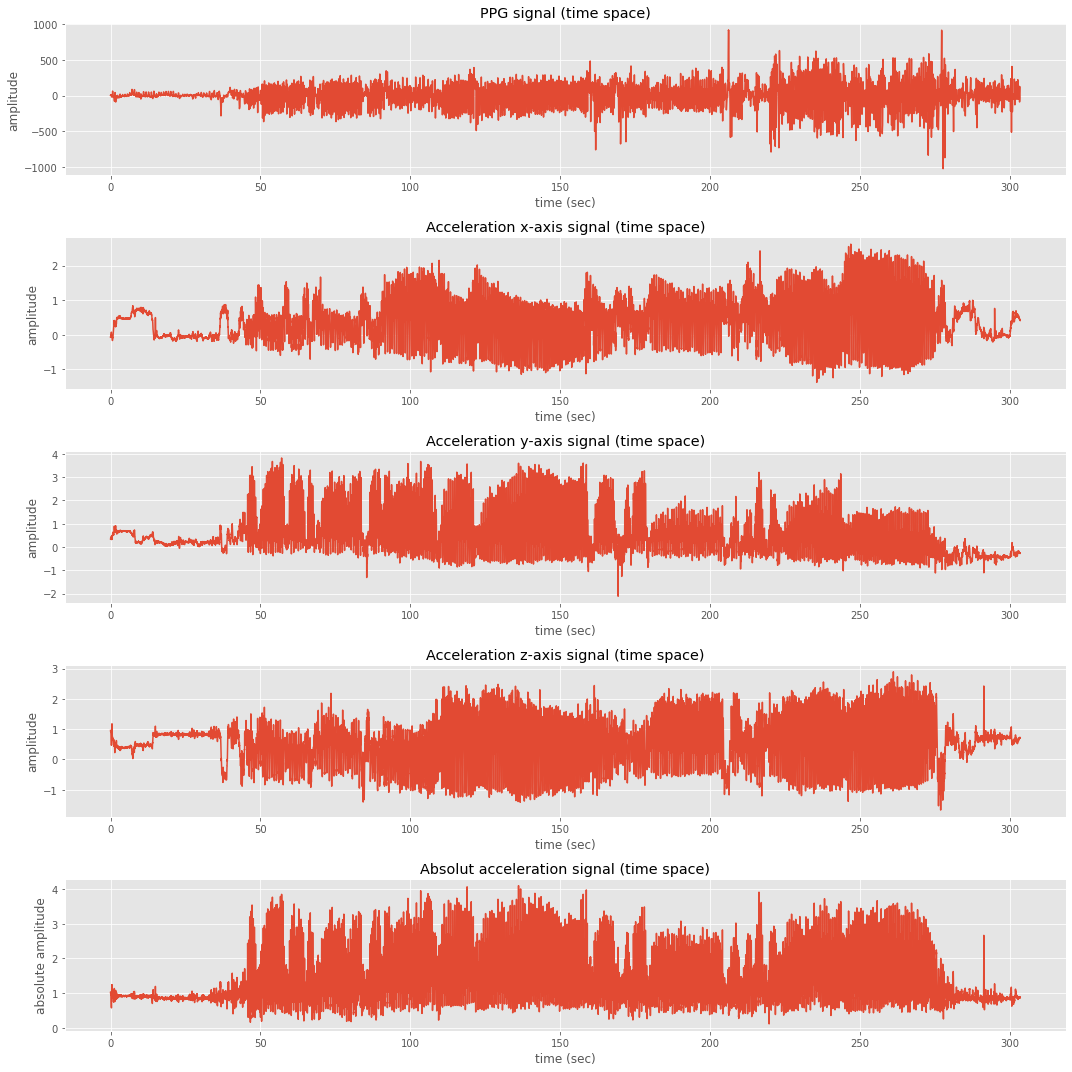

In [29]:
# timestamps in minutes
ts = np.arange(0, len(ppg), 1) / FREQ_SAMPLE
fig, axarr = plt.subplots(5, figsize=(15, 15))
axarr[0].plot(ts, ppg)
axarr[0].set_xlabel('time (sec)')
axarr[0].set_ylabel('amplitude')
axarr[0].set_title('PPG signal (time space)')
axarr[1].plot(ts, accx)
axarr[1].set_xlabel('time (sec)')
axarr[1].set_ylabel('amplitude (mV)')
axarr[1].set_title('Acceleration x-axis signal (time space)')
axarr[2].plot(ts, accy)
axarr[2].set_xlabel('time (sec)')
axarr[2].set_ylabel('amplitude (mV)')
axarr[2].set_title('Acceleration y-axis signal (time space)')
axarr[3].plot(ts, accz)
axarr[3].set_xlabel('time (sec)')
axarr[3].set_ylabel('amplitude (mV)')
axarr[3].set_title('Acceleration z-axis signal (time space)')
axarr[4].plot(ts, acc)
axarr[4].set_xlabel('time (sec)')
axarr[4].set_ylabel('absolute amplitude (mV)')
axarr[4].set_title('Absolut acceleration signal (time space)')
plt.tight_layout()

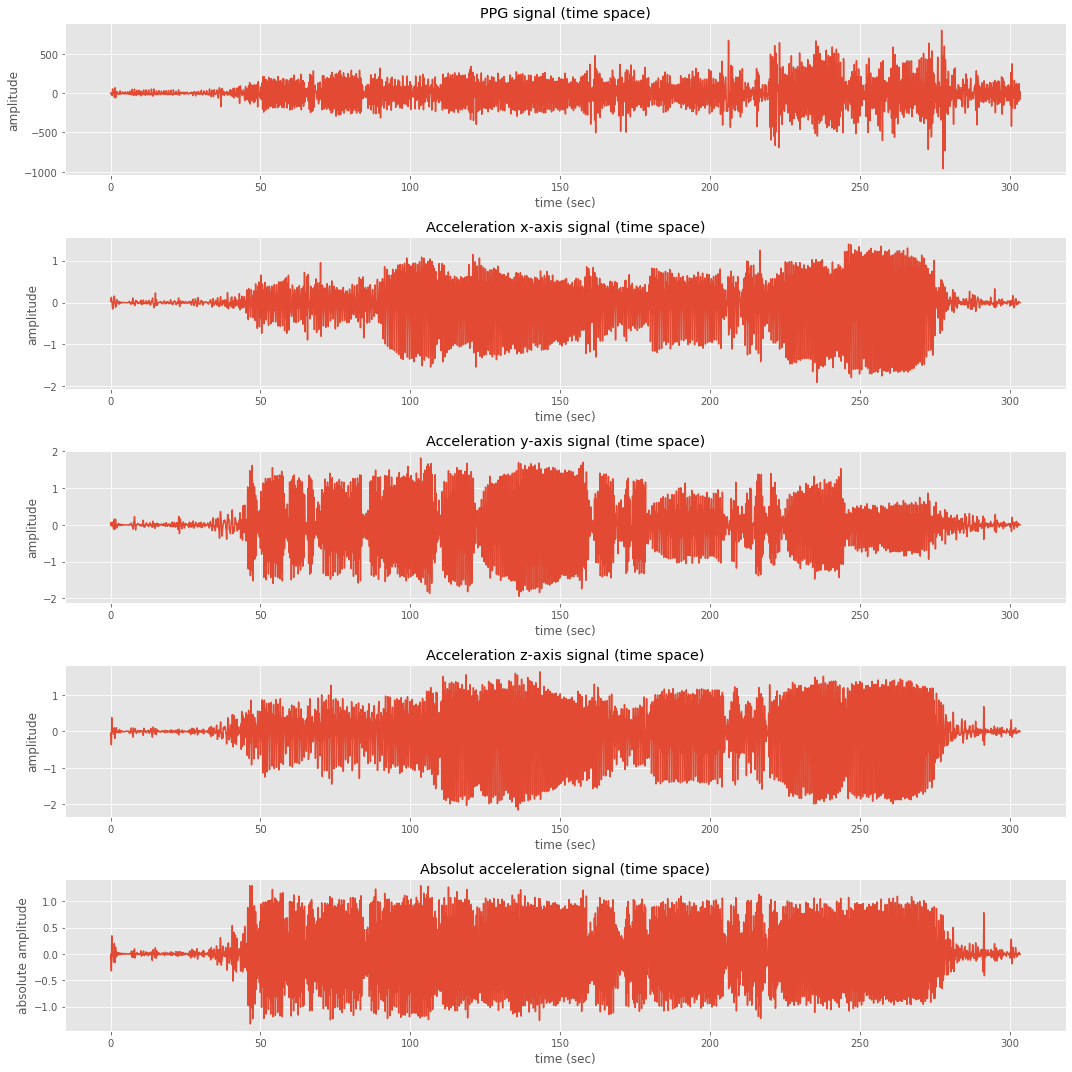

In [28]:
# timestamps in minutes
fig, axarr = plt.subplots(5, figsize=(15, 15))
axarr[0].plot(ts, ppg_filtered)
axarr[0].set_xlabel('time (sec)')
axarr[0].set_ylabel('amplitude')
axarr[0].set_title('PPG signal (time space)')
axarr[1].plot(ts, accx_filtered)
axarr[1].set_xlabel('time (sec)')
axarr[1].set_ylabel('amplitude')
axarr[1].set_title('Acceleration x-axis signal (time space)')
axarr[2].plot(ts, accy_filtered)
axarr[2].set_xlabel('time (sec)')
axarr[2].set_ylabel('amplitude')
axarr[2].set_title('Acceleration y-axis signal (time space)')
axarr[3].plot(ts, accz_filtered)
axarr[3].set_xlabel('time (sec)')
axarr[3].set_ylabel('amplitude')
axarr[3].set_title('Acceleration z-axis signal (time space)')
axarr[4].plot(ts, acc_filtered)
axarr[4].set_xlabel('time (sec)')
axarr[4].set_ylabel('absolute amplitude')
axarr[4].set_title('Absolut acceleration signal (time space)')
plt.tight_layout()

In [83]:
spec.shape

(501, 148)

In [84]:
ppg_ref.shape

(148,)

In [88]:
spec[:, 0]

array([1.61242595e-04, 4.12239161e-04, 1.92518383e-03, 2.28884304e-02,
       1.39923755e+00, 4.22906797e+00, 2.06661317e+01, 1.32915354e+01,
       5.52473115e+01, 1.79343102e+02, 2.13251353e+02, 4.56558409e+00,
       7.12656670e+00, 2.67055949e+01, 3.42169821e+01, 2.75322894e+01,
       1.19579978e+01, 1.81142732e+00, 5.31655962e+01, 1.90804151e+02,
       1.13655437e+02, 3.75104568e+01, 6.82539200e+00, 1.92158547e+01,
       1.30004825e+01, 2.01156094e+01, 7.66790110e+00, 2.29878124e+00,
       5.08676688e+00, 2.48104824e+01, 1.98041887e+01, 1.19926973e+00,
       2.17660006e+00, 9.51970299e-01, 5.53827279e-01, 1.90064786e-01,
       1.49772306e-01, 6.54120648e-02, 3.65016606e-02, 1.79220361e-02,
       5.91211166e-04, 1.11645354e-03, 7.21684592e-05, 2.14000646e-04,
       1.51726844e-04, 5.02885823e-06, 2.20343355e-06, 2.69307072e-05,
       4.97183519e-05, 6.73660525e-06, 5.75132163e-06, 4.02026213e-06,
       1.22797174e-06, 2.21309909e-08, 8.27020687e-07, 7.17589847e-08,
      

In [90]:
spec_freqs[np.argmax(spec[:, 0])] * 60

75.0

In [87]:
fft

array([ 133.57341801,  154.67888983,  209.88334434,  301.26126784,
        487.26622524, 1306.70012251, 1804.80474213,  372.51978835,
       2161.48191687,  462.57484868, 7081.29713096, 4886.45880857,
       1521.28365502, 1298.55486063, 1620.42710478, 1720.17077222,
       1468.39089533, 2068.38494313, 3200.50944756, 3955.55334632,
       5016.07629562, 5168.20776014, 1920.87450667,  813.38557954,
       1102.15453065, 1428.85985104,  770.60546363,  540.6995827 ,
        368.26496518, 1359.97925907, 1215.31853365, 1125.13793876,
       1061.63070126,  532.60342204,  149.13719071,  243.81355051,
        401.6002189 ,  358.08634365,  259.49457919,  269.35580021,
        268.4685714 ,  270.04096869,  252.8521262 ,  231.60527601,
        218.54104575,  212.67087149,  207.40004674,  202.2167727 ,
        195.07182643,  189.33523306,  183.74855742,  179.04761758,
        174.41404864,  170.44849465,  166.44790291,  162.7198542 ,
        159.16044209,  155.52505673,  152.35628838,  149.22109

In [40]:
ppg_ref[0]

74.33920704845815

In [75]:
240/60

4.0

In [81]:
np.fft.rfftfreq(n, 1/FREQ_SAMPLE)

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125,  6.25 ,  6.375,  6.5  ,  6.625,  6.75 ,  6.875,
        7.   ,  7.125,  7.25 ,  7.375,  7.5  ,  7.625,  7.75 ,  7.875,
        8.   ,  8.125,  8.25 ,  8.375,  8.5  ,  8.625,  8.75 ,  8.875,
        9.   ,  9.125,  9.25 ,  9.375,  9.5  ,  9.625,  9.75 ,  9.875,
       10.   , 10.125, 10.25 , 10.375, 10.5  , 10.625, 10.75 , 10.875,
       11.   , 11.125, 11.25 , 11.375, 11.5  , 11.625, 11.75 , 11.875,
       12.   , 12.125, 12.25 , 12.375, 12.5  , 12.625, 12.75 , 12.875,
       13.   , 13.125, 13.25 , 13.375, 13.5  , 13.625, 13.75 , 13.875,
      

In [41]:
n = window_length
freqs = np.fft.rfftfreq(n, 1/FREQ_SAMPLE)
fft = np.abs(np.fft.rfft(ppg_filtered[:window_length], n))

In [49]:
freqs[np.argmax(fft)] * 60

75.0

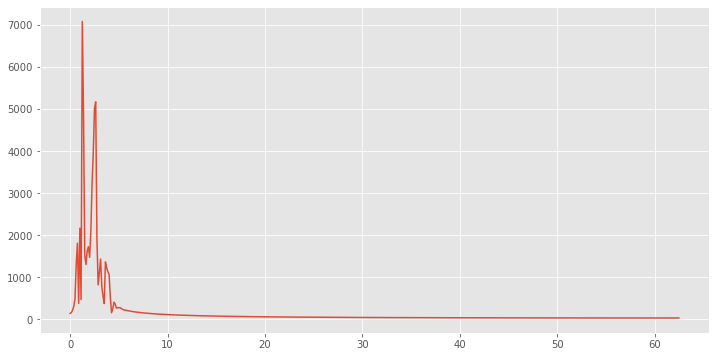

In [46]:
plt.plot(freqs, fft)

(0.0, 10.0)

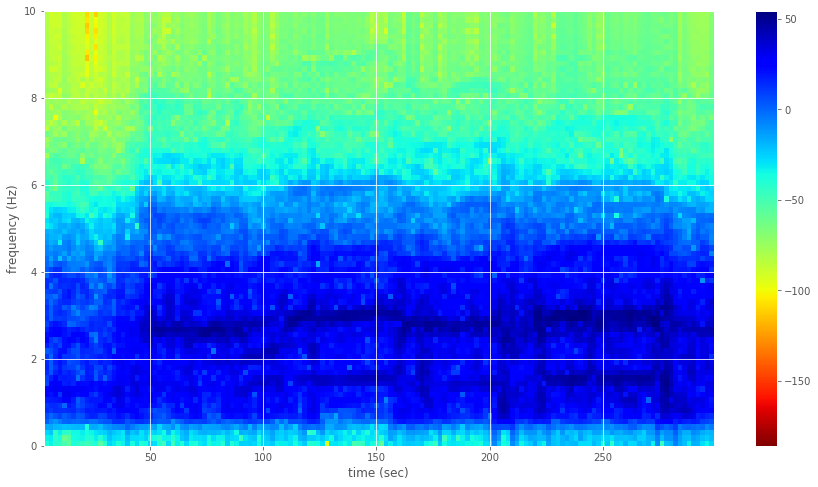

In [51]:
plt.figure(figsize=(15, 8))
# we are splitting data x into NFFT length segments (local/smaller time segments) and compute the spectrum 
# (fourier transform) of each section.
# freq contains the frequencies containing to the rows (y-axis ^= frequencies) in the spectrum
# Fs: sample frequency
# NFFT: number of data points in each segment -> we will have ca. len(x)/NFFT segments 
# (=time segments = rows in spec matrix). 
# This is only approximately because we most likely divide the signel by a number that is an exact divisor of len(x)
# here: we have a sample frequency of fs Hz and calculate FFT in intervals of length NFFT=fs*10 (= 10 sec).
spec, spec_freqs, _, _ = plt.specgram(x=ppg_filtered, NFFT=window_length, Fs=FREQ_SAMPLE,
                                      noverlap=window_length-window_shift, cmap='jet_r')
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.colorbar()
# cut frequency at 10Hz:
plt.ylim((0, 10))

In [53]:
spec_freqs.shape

(501,)

In [54]:
spec.shape

(501, 148)

In [9]:
spec.shape

(501, 148)

### Labels

In [11]:
ppg_ref = load_labels(ref_fls[0])
ts_center = np.arange(0, len(ppg_ref), 1) * WINDOW_SHIFT_SEC + WINDOW_LENGTH_SEC / 2
ts_lower = np.arange(0, len(ppg_ref), 1) * WINDOW_SHIFT_SEC
ts_upper = np.arange(0, len(ppg_ref), 1) * WINDOW_SHIFT_SEC + WINDOW_LENGTH_SEC

Text(0.5, 1.0, 'Reference PPG signal (labels)')

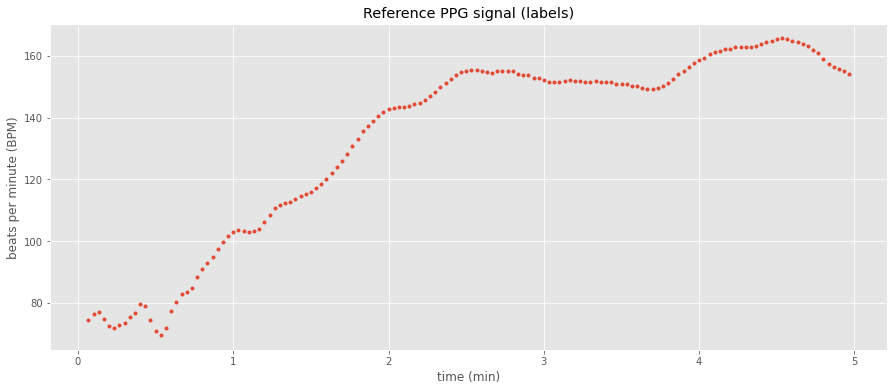

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(ts_center / 60, ppg_ref, '.')
ax.set_xlabel('time (min)')
ax.set_ylabel('beats per minute (BPM)')
ax.set_title('Reference PPG signal (labels)')

In [13]:
Evaluate()

1.0

### fft

In [ ]:
# def RunPulseRateAlgorithm(data_fl, ref_fl):
#     # Sample Frequency
#     fs = 125
#     # Window to calculate reference pulse rate
#     win_len = 8
#     # Difference between time windows
#     win_shift = 2    
       
#     reg, scores = load_regressor()
#     targets, features, sigs, subs = load_data(data_fl, ref_fl)
#     error, confidence = [], []
#     for i,feature in enumerate(features):
#         est = reg.predict(np.reshape(feature, (1, -1)))[0]
        
#         # Calculate confidence
#         ppg, accx, accy, accz = sigs[i]
        
#         ppg = bandpass_filter(ppg)        
#         accx = bandpass_filter(accx)
#         accy = bandpass_filter(accy)
#         accz = bandpass_filter(accz)        
        
#         n = len(ppg) * 3
#         freqs = np.fft.rfftfreq(n, 1/fs)
#         fft = np.abs(np.fft.rfft(ppg,n))
#         fft[freqs <= 40/60.0] = 0.0
#         fft[freqs >= 240/60.0] = 0.0
    
#         # Max magnitude frequency
#         est_fs = est / 55.0
#         fs_win = 30  / 60.0
#         fs_win_e = (freqs >= est_fs - fs_win) & (freqs <= est_fs +fs_win)
#         conf = np.sum(fft[fs_win_e])/np.sum(fft)
        
#         error.append(np.abs((est-targets[i])))
#         confidence.append(conf)
#     return np.array(error), np.array(confidence)

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 